If your having problems running this on your machine. do the following...


brew install apache-spark

#setting env variable:

export SPARK_HOME="/usr/local/Cellar/apache-spark/2.1.0/libexec/"

export PYTHONPATH=$SPARK_HOME/python:$SPARK_HOME/python/build:$PYTHONPATH

export PYTHONPATH=$SPARK_HOME/python/lib/py4j-0.10.4-src.zip:$PYTHONPATH

export PYSPARK_DRIVER_PYTHON=jupyter

export PYSPARK_DRIVER_PYTHON_OPTS=notebook


pyspark


In [244]:
# MUST AT LEAST RUN THIS ONE TO GET THE DATA VARIABLE. OTHERS ARE OPTIONAL.
%matplotlib inline
from pyspark.sql import Row
from pyspark import SparkContext
import seaborn as sns
import re
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col,udf, unix_timestamp
from pyspark.sql.types import DateType
from pyspark.sql.functions import udf
from pyspark.sql.types import DataType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
import locale
from pyspark.sql.functions import split, explode

data = spark.read.csv("Nomis Solutions_Data Part I.csv", header=True, inferSchema=True)
data = data.where(data.Tier.isNotNull()) # remove bad data, 3 entries have 'null' for Tier
for column in data.columns: #fix column names
    data = data.withColumnRenamed(column, column.lower().replace(' ','_'))
data = data.withColumn('rate', data.rate/100)
data = data.withColumn('competition_rate', data.competition_rate/100)
data = data.withColumn('spread__rate_vs_competition', (data.rate - data.competition_rate)) #calculate the spread

data = data.withColumn('cost_of_funds', data.cost_of_funds/100)
print(data.count())

# calculate out the NPV
def npv(loan, term, APR, cost_of_capital):
    interest = loan*APR # http://mathforum.org/dr.math/faq/faq.interest.html
    Cfs = []
    Cfs.append(-loan)
    for i in range(1,int(term/12)+1):
        Cfs.append(interest)
    Cfs[-1] += loan

    disc_Cfs = []
    for t,cf in enumerate(Cfs):
         disc_Cfs.append(cf / (1+cost_of_capital)**t)
    return sum(disc_Cfs)
    
print(npv(1000, 60, 0.07, 0.01))
npv = udf(npv, returnType=DoubleType())
data = data.withColumn('npv', npv("amount", "term", "rate", "cost_of_funds")) #.select("approve_date", "amount", "term", "rate", "cost_of_funds", "npv")

# calculate out the year
def year(stringDate):
    return datetime.strptime(stringDate, '%m/%d/%y').year
print(year("7/1/02"))
year = udf(year, returnType=IntegerType())
data = data.withColumn('s_approve_date', data.approve_date)
data = data.withColumn('year', year("approve_date"))

def date(stringDate):
    return datetime.strptime(stringDate, '%m/%d/%y')
print(date("7/1/02"))
date = udf(date, returnType=DateType())
data = data.withColumn('approve_date', date("approve_date"))


208085
291.2058743595071
2002
2002-07-01 00:00:00


In [170]:
data

DataFrame[tier: int, fico: int, approve_date: date, term: int, amount: double, previous_rate: string, car__type: string, competition_rate: double, outcome: int, rate: double, cost_of_funds: double, partner_bin: int, spread__rate_vs_competition: double, npv: double, s_approve_date: string, year: int]

In [171]:
data.show(1)

+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+---------------------------+-----------------+--------------+----+
|tier|fico|approve_date|term| amount|previous_rate|car__type|competition_rate|outcome|               rate|cost_of_funds|partner_bin|spread__rate_vs_competition|              npv|s_approve_date|year|
+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+---------------------------+-----------------+--------------+----+
|   3| 695|  2002-07-01|  72|35000.0|             |        N|          0.0625|      0|0.07490000000000001|     0.018388|          1|       0.012400000000000008|11139.70700051541|        7/1/02|2002|
+----+----+------------+----+-------+-------------+---------+----------------+-------+-------------------+-------------+-----------+---------------------------+-----------------+--------------+----+
only 

In [195]:
data.describe('fico', 'spread__rate_vs_competition').show()

+-------+----------------+---------------------------+
|summary|            fico|spread__rate_vs_competition|
+-------+----------------+---------------------------+
|  count|          208085|                     208085|
|   mean|726.731407838143|       0.008159716221736044|
| stddev| 44.783564051538|       0.014363978607644651|
|    min|             587|       -0.01859999999999999|
|    max|             854|        0.11279999999999998|
+-------+----------------+---------------------------+



In [ ]:
sns.violinplot(x="day", y="total_bill", data=data.toPandas())


In [ ]:
data.describe('rate','cost_of_funds', 'partner_bin', 'spread').show()

In [179]:
data.groupBy('tier').count().sort('tier').show()

+----+------+
|tier| count|
+----+------+
|   1|100261|
|   2| 45472|
|   3| 39570|
|   4| 22782|
+----+------+



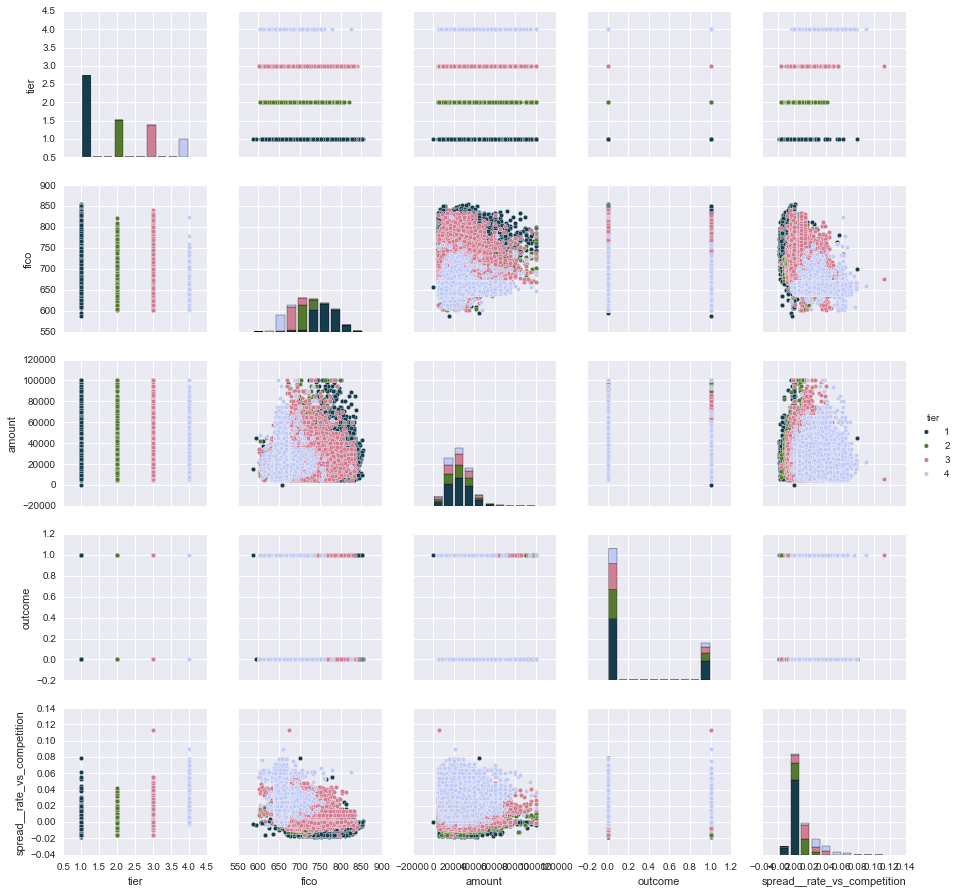

In [188]:
# fico vs amount is interesting
x=data.select('tier','fico','amount','outcome', 'spread__rate_vs_competition', 'cost_of_funds', 'npv').toPandas()
sns.pairplot(x, hue='outcome', palette="cubehelix")

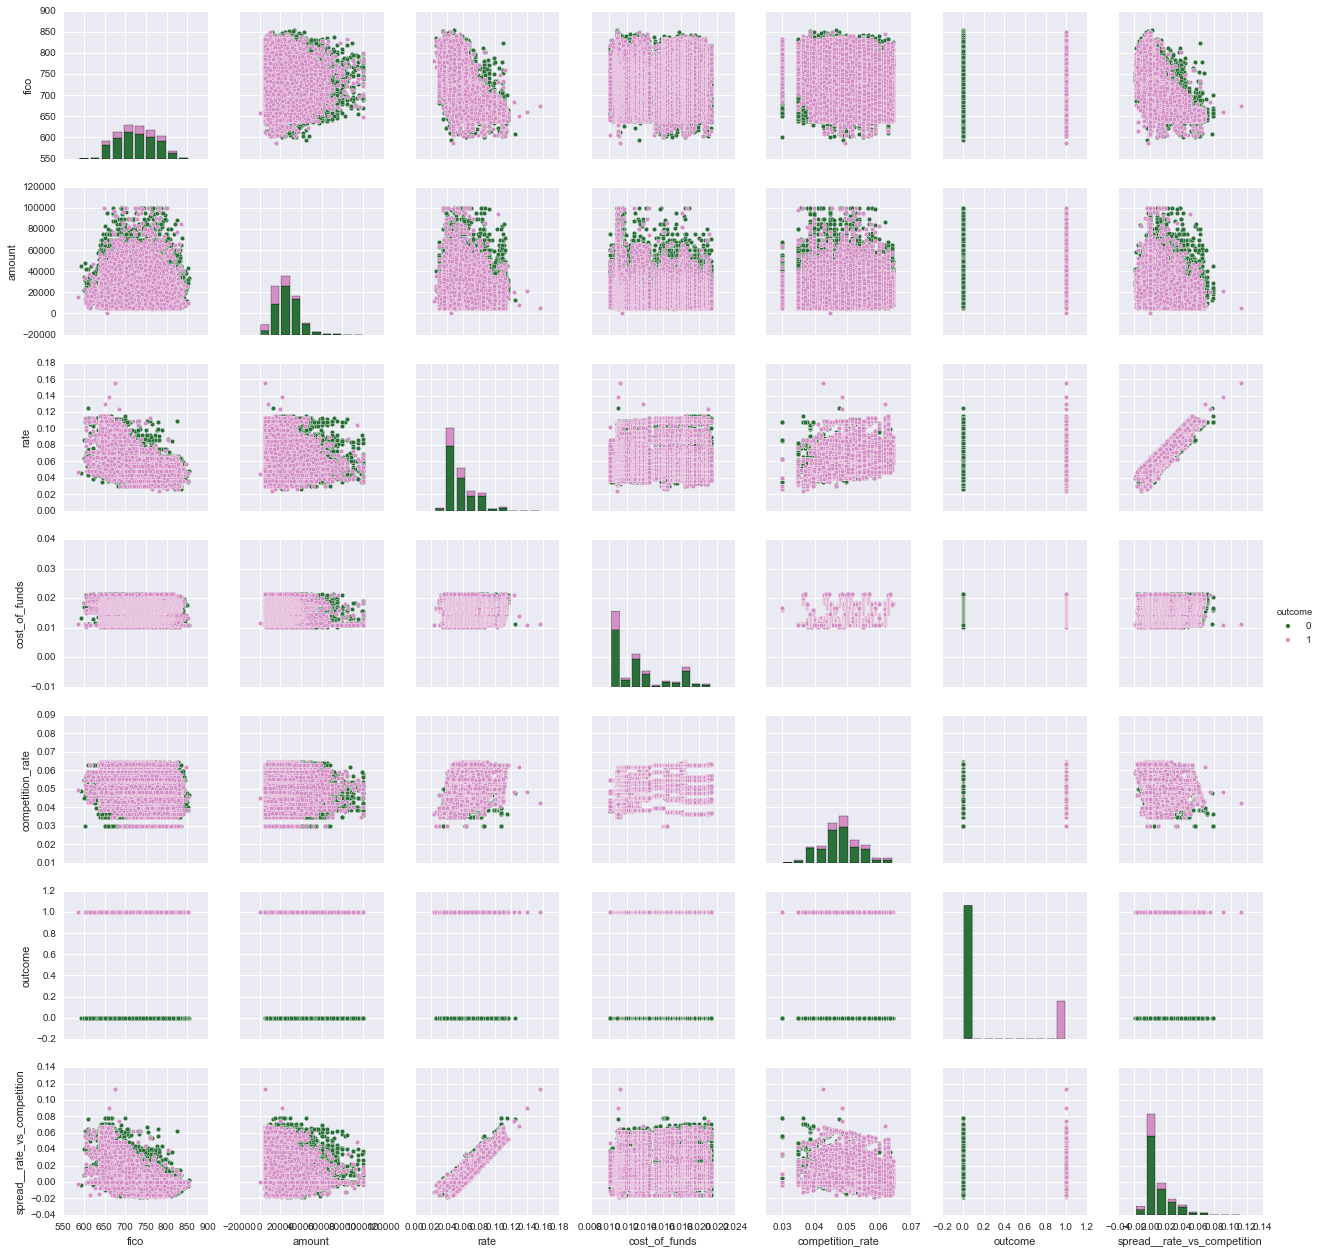

In [196]:
# amount vs amount shows that the loans they are approving are low $ amount loans
# rate vs rate shows the loans they are approving are low interest rate loans
#x=data.select('tier','fico','amount','rate', 'cost_of_funds').toPandas()
x=data.select('fico','amount','rate', 'cost_of_funds', 'competition_rate', 'outcome', 'spread__rate_vs_competition').toPandas()
sns.pairplot(x, hue='outcome', palette="cubehelix")


$NPV=\sum_{n=1}^{n} \frac{Cn}{(1+r)^n} - Co$

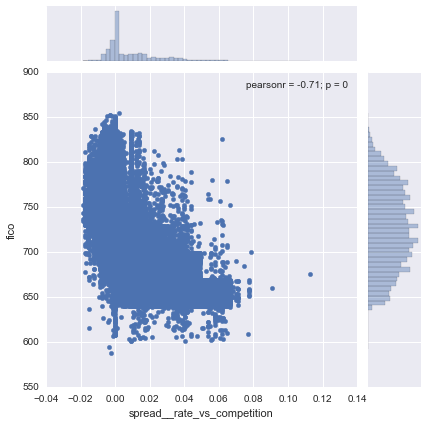

In [247]:
x=data.select('fico','amount','rate', 'cost_of_funds', 'competition_rate', 'outcome', 'spread__rate_vs_competition').toPandas()
sns.jointplot(x="spread__rate_vs_competition", y="fico", data=x)

In [ ]:
y=data.where(data.outcome==1).select('fico','amount','rate', 'cost_of_funds', 'competition_rate', 'outcome', 'spread__rate_vs_competition').toPandas()
sns.jointplot(x="spread__rate_vs_competition", y="fico", data=y)

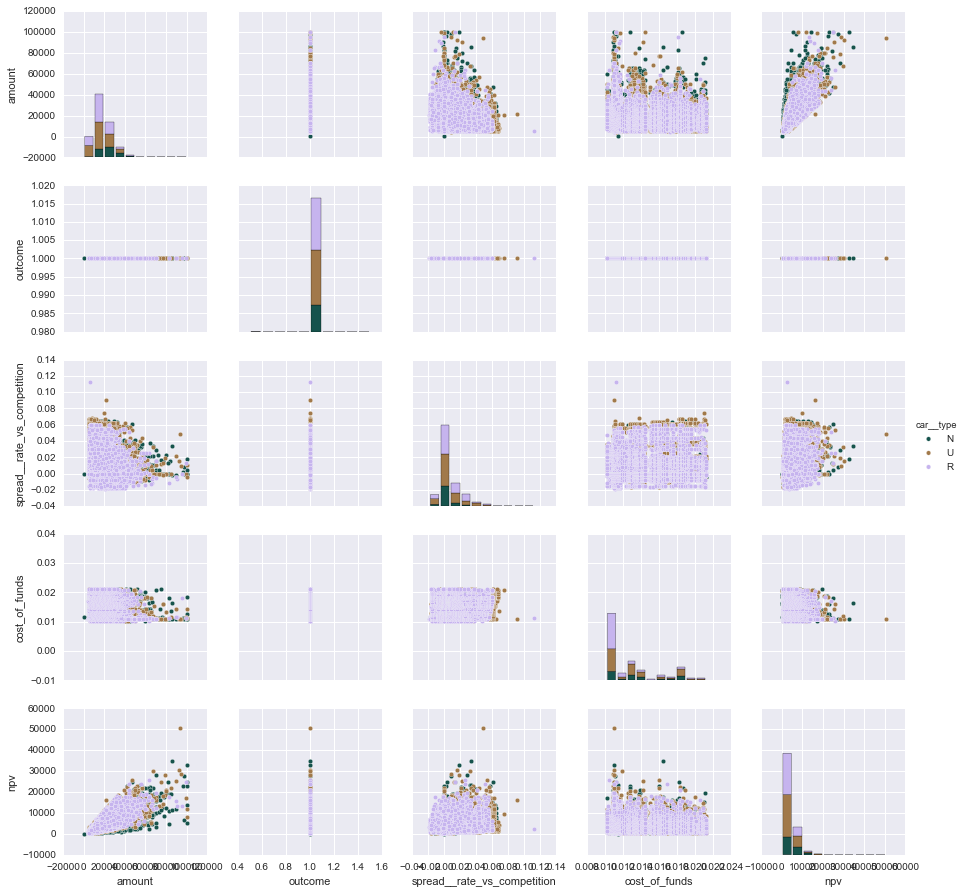

In [210]:
# fico vs amount is interesting
x=data.where(data.outcome==1).select('car__type','amount','outcome', 'spread__rate_vs_competition', 'cost_of_funds', 'npv').toPandas()
sns.pairplot(x, hue='car__type', palette="cubehelix")

In [285]:
y=data.where(data.outcome==1).select('car__type').toPandas()
y['car_type_n'] = (y['car__type']=='N') * 1
y['car_type_u'] = (y['car__type']=='U') * 1
y['car_type_r'] = (y['car__type']=='R') * 1


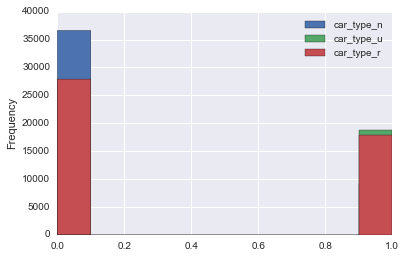

In [288]:
#sns.jointplot(x="car_type_n", y="fico", data=y)
y.plot.hist('car_type_r')

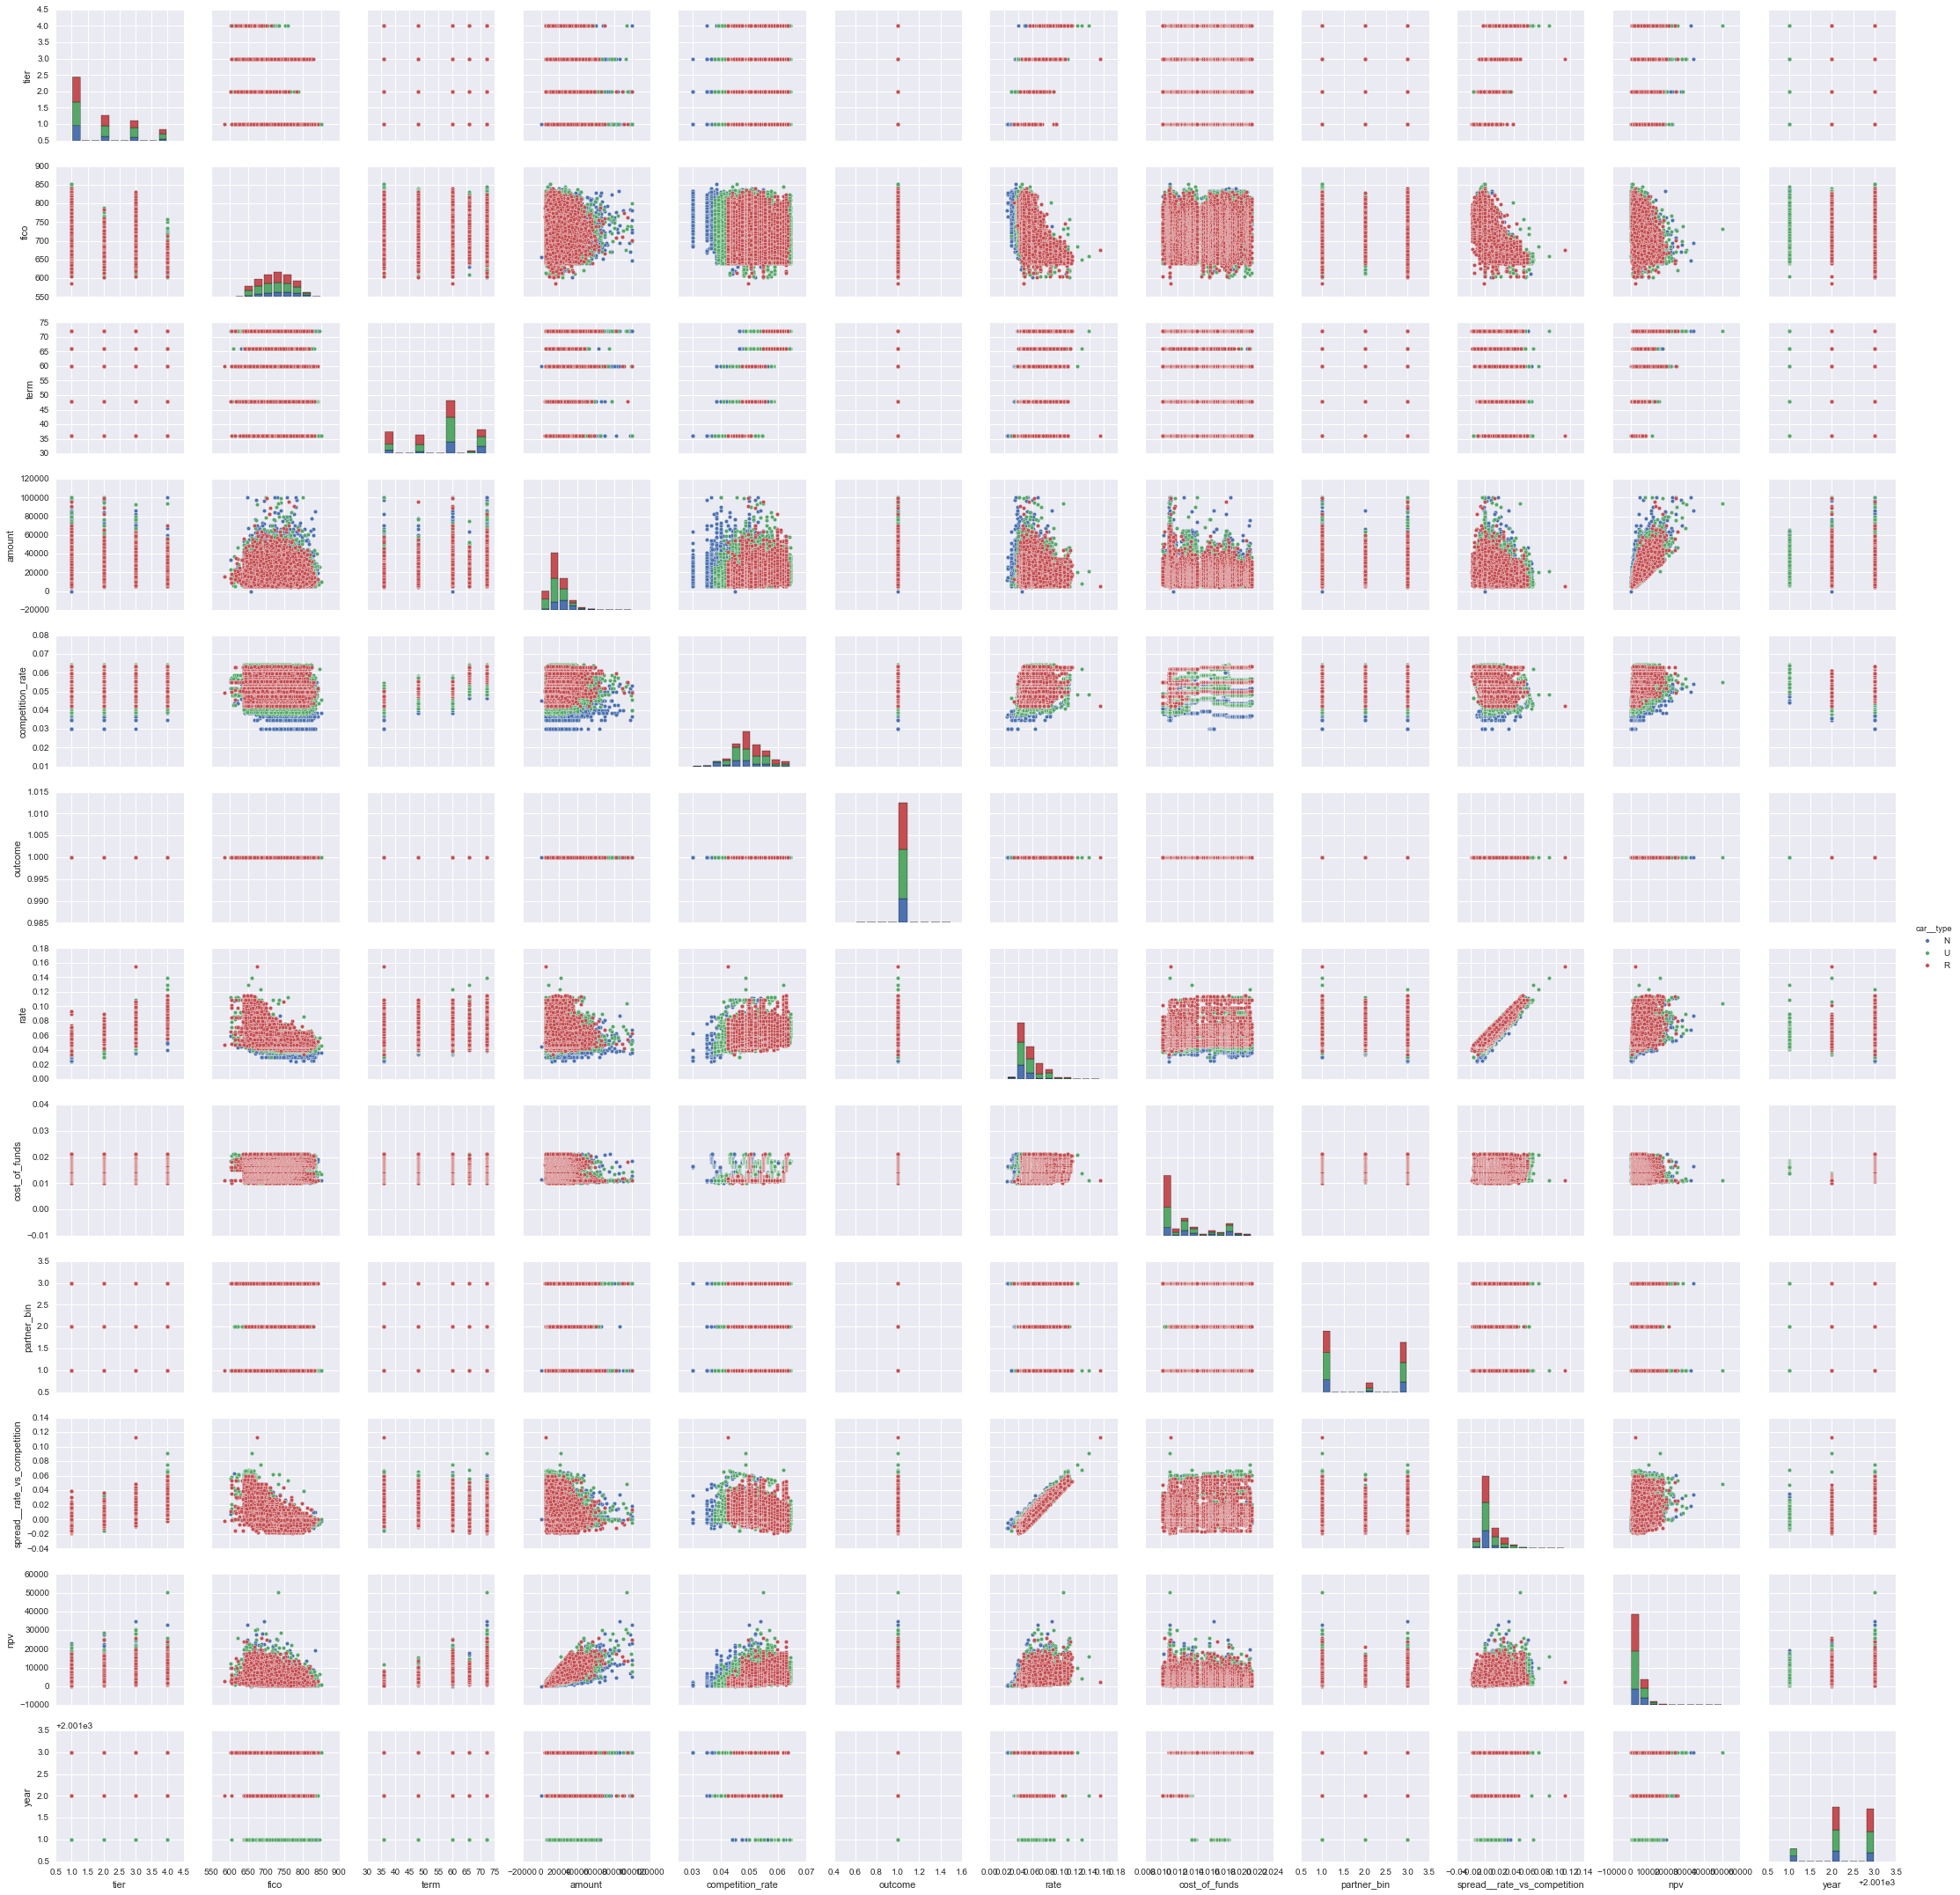

In [294]:
z=data.where(data.outcome==1).toPandas()
sns.pairplot(z, hue="car__type")


In [177]:
# distribution of loans by origination year
data.groupBy('year').count().sort('year').show()

+----+------+
|year| count|
+----+------+
|2002| 27713|
|2003|103658|
|2004| 76714|
+----+------+



In [178]:
IRR

NameError: name 'IRR' is not defined

In [190]:
import pyspark.sql.functions as func
agg_npv = data.where(data.outcome==1).groupBy('year').sum('npv').toPandas()
agg_npv = agg_npv.sort_values('year',0)
#pd.options.display.float_format = '${:,.2f}'.format
agg_npv = agg_npv.set_index('year')
print(agg_npv)

          sum(npv)
year              
2002  1.913898e+07
2003  7.883488e+07
2004  7.628669e+07


In [191]:
cost_of_capital = data.where(data.outcome==1)#.where(data.approve_date.isNotNull())# .where(data.year == '2003')
cost_of_capital = cost_of_capital.toPandas()

for year in cost_of_capital['year'].unique():
    print(year, cost_of_capital[cost_of_capital['year']==year]['cost_of_funds'].mean())
avg_coc = [0.01689893351567463, 0.01177518111180385, 0.013632502898191337]

print()
print('avg rate')
for year in cost_of_capital['year'].unique():
    print(year, cost_of_capital[cost_of_capital['year']==year]['rate'].mean())
#avg_apr = [0.01689893351567463, 0.01177518111180385, 0.013632502898191337]


2002 0.01689893351567463
2003 0.01177518111180385
2004 0.013632502898191337

avg rate
2002 0.056085567010309686
2003 0.052953575711063794
2004 0.05896719841466425


In [ ]:
disc_Cfs = []
for t,cf in enumerate(agg_npv['sum(npv)']):
     disc_Cfs.append(cf / (1+avg_coc[t])**t)
print(sum(disc_Cfs))


In [308]:
x=data.select('car__type', 'spread__rate_vs_competition'). groupBy('car__type').agg(func.count('car__type'), func.avg('spread__rate_vs_competition')).toPandas()
#sns.jointplot(x="spread__rate_vs_competition", y="amount", data=x,  hue="car__type")
#sns.barplot(x="spread__rate_vs_competition", y="spread__rate_vs_competition", palette="Set3", data=x, hue='car__type')
x


,car__type,count(car__type),avg(spread__rate_vs_competition)
0,U,41816,0.012476
1,N,119059,0.006549
2,R,47210,0.008398


In [ ]:
NPV for tier, FICO, approve date, term, amount

In [ ]:
EDA

In [168]:
x = data.where(data.outcome==1).select('approve_date', 's_approve_date', 'spread__rate_vs_competition')
x = x.groupBy('approve_date').agg(func.first('s_approve_date').alias('date'), func.mean('spread__rate_vs_competition').alias('avg'), func.max('spread__rate_vs_competition').alias('max'),func.min('spread__rate_vs_competition').alias('min'))
x = x.sort('date')
x = x.toPandas()
x = x.set_index(x.date)



,approve_date,date,avg,max,min
date,,,,,
1/1/03,2003-01-01,1/1/03,-0.002733,0.0079,-0.0111
1/1/04,2004-01-01,1/1/04,0.003960,0.0140,-0.0071
1/10/03,2003-01-10,1/10/03,0.001558,0.0300,-0.0080
1/10/04,2004-01-10,1/10/04,0.004100,0.0334,-0.0120
1/11/03,2003-01-11,1/11/03,0.002226,0.0290,-0.0086
1/11/04,2004-01-11,1/11/04,0.005424,0.0250,-0.0174
1/12/03,2003-01-12,1/12/03,0.004180,0.0269,-0.0060
1/12/04,2004-01-12,1/12/04,0.005478,0.0380,-0.0174
1/13/03,2003-01-13,1/13/03,-0.001220,0.0269,-0.0076
